In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
# read data
#data = pd.read_csv('Data/Data Merged.csv')
#data.head()

# Calculate graduation rate

In [3]:
# keep only non-zero international completers, & at least 3 international students in 2017 cohort
data_intl_grad = data[data.GRNRALT_x > 0] 
data_intl_grad = data_intl_grad[data_intl_grad.GRNRALT_y > 2] 
data_intl_grad.shape # (1222, 300)

(1222, 300)

Text(0.5, 0, 'graduation rate')

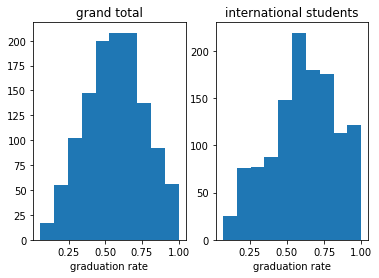

In [13]:
#'GRTOTLT', 'GRNRALT'

plt.subplot(1,2,1)
plt.hist(data_intl_grad['GRTOTLT_rate'])
plt.title('grand total')
plt.xlabel('graduation rate')
plt.subplot(1,2,2)
plt.hist(data_intl_grad['GRNRALT_rate']) 
plt.title('international students')
plt.xlabel('graduation rate') 

(array([ 93., 952., 142.,  27.,   5.,   2.,   0.,   0.,   0.,   1.]),
 array([0.3705458 , 0.82406767, 1.27758955, 1.73111142, 2.1846333 ,
        2.63815518, 3.09167705, 3.54519893, 3.99872081, 4.45224268,
        4.90576456]),
 <a list of 10 Patch objects>)

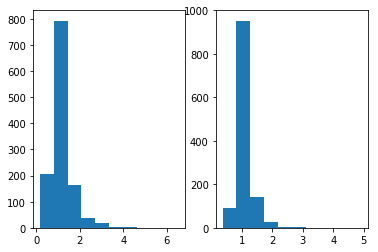

In [35]:
# calculate an adjusted proportion with Bayesian formula
# but first, look at a general distribution of 
plt.subplot(1,2,1)
plt.hist(data_intl_grad['GRNRALT_rate']/data_intl_grad['GRTOTLT_rate'])
plt.subplot(1,2,2)
plt.hist(graduation_ratio)
# most are close to 1
# so I can use the grand total proportion as my prior

In [9]:
GRNRALT_rate_adj = (data_intl_grad['GRNRALT_x'] + 10*data_intl_grad['GRTOTLT_rate'])/(data_intl_grad['GRNRALT_y'] + 10)
GRNRALT_rate_adj.describe()
graduation_ratio = GRNRALT_rate_adj/data_intl_grad['GRTOTLT_rate']
graduation_ratio.describe()
data_intl_grad['GRNRALT_rate_adj'] = GRNRALT_rate_adj
data_intl_grad['graduation_ratio'] = graduation_ratio
# need success and failure numbers for binomial regression
data_intl_grad['EFYUS'] = data_intl_grad['EFYTOTLT'] - data_intl_grad['EFYNRALT']

(array([ 26.,  62.,  74., 152., 193., 233., 199., 136.,  98.,  49.]),
 array([0.10853396, 0.19768056, 0.28682717, 0.37597377, 0.46512038,
        0.55426698, 0.64341358, 0.73256019, 0.82170679, 0.9108534 ,
        1.        ]),
 <a list of 10 Patch objects>)

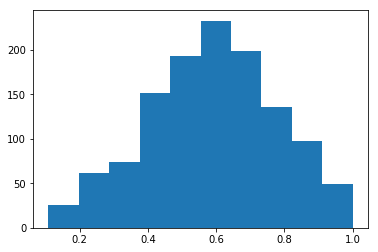

In [32]:
plt.hist(GRNRALT_rate_adj)

In [60]:
# look at who have >90% completion rate
# data_intl_grad[data_intl_grad.GRNRALT_rate>0.9][['INSTNM','ranking_US_news','GRNRALT_x','GRNRALT_y','GRTOTLT_rate','GRNRALT_rate_adj']]
# they are a mix of very great schools and schools with very small international enrollment

In [59]:
# look at who have graduation ratio > 3
#data_intl_grad[data_intl_grad.graduation_ratio>2][['INSTNM','ranking_US_news','GRNRALT_x','GRNRALT_y','GRTOTLT_rate','GRNRALT_rate_adj']]
# they are a mix of very great schools and schools with very small international enrollment
# for now, I'm not worrying about it because all >2 schools either don't have a ranking or have a 293 ranking

In [45]:
data_274_intl_grad_national_u = data_intl_grad.dropna(subset = ['ranking_US_news','good_for_intl_US_news'])
print(data_274_intl_grad_national_u.shape) # (274, 302)
#data_274_intl_grad_national_u[['good_for_intl_US_news','diverse_ind','graduation_ratio']]
data_274_intl_grad_national_u.to_csv('Data/Data national universities 274.csv')

(274, 303)


# EDA

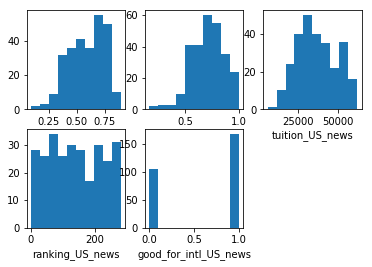

In [62]:
# look at the distributions of my features
features = ['diverse_ind','GRNRALT_rate','tuition_US_news', 'ranking_US_news', 'good_for_intl_US_news']
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.hist(data_274_intl_grad_national_u[features[i]])
    plt.xlabel(features[i])
#plt.subplot(2,3,6)
#plt.hist(data_274_intl_grad_national_u['intl_pct'])
#plt.xlabel('intl_pct')

# MVP

In [45]:
data_274_intl_grad_national_u = pd.read_csv('Data/Data national universities 274.csv')
data_274_intl_grad_national_u.head()

,Unnamed: 0,UNITID,EFFYLEV,LSTUDY,XEYTOTLT,EFYTOTLT,XEYTOTLM,EFYTOTLM,XEYTOTLW,EFYTOTLW,...,GRNRALM_rate,GRNRALW _rate,GRNRALT_rate_adj,graduation_ratio,EFYUS,diverse_ind_pct,GRNRALT_rate_pct,tuition_US_news_pct,ranking_US_news_pct,good_for_intl_US_news_pct
0,1,100663,2,1,R,13308,R,5528,R,7780,...,0.461538,0.777778,0.571621,1.080186,12944,0.518248,0.773723,0.189781,0.609489,0.308394
1,2,100706,2,1,R,7519,R,4287,R,3232,...,0.615385,0.000000,0.535915,1.102261,7302,0.620438,0.819343,0.142336,0.921533,0.808394
2,4,100751,2,1,R,35625,R,15883,R,19742,...,0.717647,0.750000,0.725785,1.069330,34595,0.864964,0.467153,0.335766,0.560219,0.308394
3,8,100858,2,1,R,23846,R,12374,R,11472,...,0.466667,0.571429,0.583067,0.761368,22568,0.916058,0.919708,0.364964,0.394161,0.808394
4,32,102049,2,1,R,3446,R,1197,R,2249,...,0.500000,1.000000,0.729032,0.961702,3357,0.956204,0.523723,0.434307,0.536496,0.808394


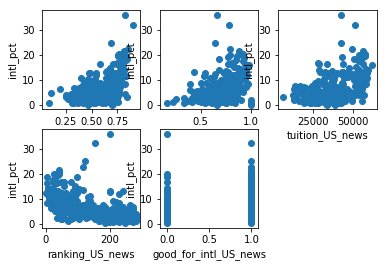

In [64]:
# gotta do some EDA, right?

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.scatter(data_274_intl_grad_national_u[features[i]], data_274_intl_grad_national_u['intl_pct'])
    plt.xlabel(features[i])
    plt.ylabel('intl_pct')

In [20]:
from sklearn.model_selection import train_test_split
np.random.seed(922)
train, test = train_test_split(data_274_intl_grad_national_u, test_size = 0.3)

In [84]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression(normalize = True)
result = linear_model.fit(
    X = train[features], 
    y = train['intl_pct'])
linear_fit = linear_model.predict(
    test[features])
linear_fit_train = linear_model.predict(
    train[features])

result.coef_
# note that later on once I have a better target, I should substitute 'GRNRALT_rate' with 'graduation_ratio'

array([ 5.65314916e-01,  1.41695328e+01,  9.05888191e-01,  6.85335493e-05,
       -1.32668367e-02])

In [26]:
import statsmodels.api as sm
linear_model=sm.OLS(
    train['intl_pct'],
    train[features])
result=linear_model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               intl_pct   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     113.3
Date:                Wed, 25 Sep 2019   Prob (F-statistic):           1.65e-54
Time:                        10:55:07   Log-Likelihood:                -555.63
No. Observations:                 191   AIC:                             1121.
Df Residuals:                     186   BIC:                             1138.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
good_for_intl_US_news     0.38

In [85]:
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, mean_absolute_error
print('explained_variance_score',explained_variance_score(y_true = test['intl_pct'], y_pred = linear_fit))
print('mean_squared_error',mean_squared_error(y_true = test['intl_pct'], y_pred = linear_fit))
print('r2_score',r2_score(y_true = test['intl_pct'], y_pred = linear_fit))
print('mean_absolute_error',mean_absolute_error(y_true = test['intl_pct'], y_pred = linear_fit))
print('training r2_score',r2_score(y_true = train['intl_pct'], y_pred = linear_fit_train))

explained_variance_score 0.43297636000015727
mean_squared_error 14.032022710306649
r2_score 0.3914465590462777
mean_absolute_error 3.046857693061481
training r2_score 0.38576955298137283


# Binomial regression

In [2]:
data_274_intl_grad_national_u = pd.read_csv('Data/Data national universities 274.csv')

In [3]:
from sklearn.model_selection import train_test_split
np.random.seed(922)
train, test = train_test_split(data_274_intl_grad_national_u, test_size = 0.3)

In [73]:
# fit binomial regression model
import statsmodels.api as sm
binomial_model=sm.GLM(
    train[['EFYNRALT','EFYUS']], #[success, failure]
    train[features],
    family = sm.families.Binomial())
result=binomial_model.fit()
print(result.summary())
result.params

                   Generalized Linear Model Regression Results                   
Dep. Variable:     ['EFYNRALT', 'EFYUS']   No. Observations:                  191
Model:                               GLM   Df Residuals:                      186
Model Family:                   Binomial   Df Model:                            4
Link Function:                     logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -34184.
Date:                   Mon, 30 Sep 2019   Deviance:                       66821.
Time:                           17:46:44   Pearson chi2:                 8.05e+04
No. Iterations:                        7   Covariance Type:             nonrobust
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
diverse_ind               1.2622      0.018     71.391      0.000       1.228     

diverse_ind              1.262204
GRNRALT_rate            -2.707079
tuition_US_news         -0.000005
ranking_US_news         -0.010300
good_for_intl_US_news   -0.106220
dtype: float64

In [74]:
# get prediction
pred_test = result.predict(test[features])
pred_train = result.predict(train[features])

In [77]:
# prediction with new value, MVP
value = 100663
pred0 = result.predict(data_274_intl_grad_national_u[data_274_intl_grad_national_u.UNITID==value][features])
new_x = data_274_intl_grad_national_u[data_274_intl_grad_national_u.UNITID==value][features]
new_x['diverse_ind'] = new_x['diverse_ind']*1.1
new_x
pred1 = result.predict(new_x)
print(pred0)
print(pred1)
print(pred1-pred0)

0    0.058971
dtype: float64
0    0.063364
dtype: float64
0    0.004393
dtype: float64


Text(0, 0.5, 'y')

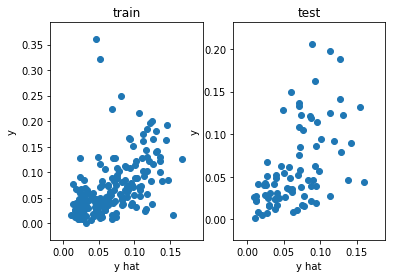

In [75]:
plt.subplot(1,2,1)
plt.scatter(pred_train,train['intl_pct']/100)
plt.title('train')
plt.xlabel('y hat')
plt.ylabel('y')
plt.subplot(1,2,2)
plt.scatter(pred_test,test['intl_pct']/100)
plt.title('test')
plt.xlabel('y hat')
plt.ylabel('y')

Text(0, 0.5, '% Enrolled (Actual)')

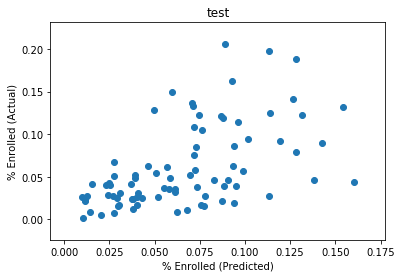

In [78]:
plt.scatter(pred_test,test['intl_pct']/100)
plt.title('test')
plt.xlabel('% Enrolled (Predicted)')
plt.ylabel('% Enrolled (Actual)')

# Binomial Regression - normalized features

In [63]:
# normalization
from sklearn.preprocessing import scale

feat_normalize = scale(data_274_intl_grad_national_u[features[:-1]],  axis=0)
feat_normalize = pd.DataFrame(feat_normalize, columns = [features[:-1]])
#data_274_intl_grad_national_u[features[-1]])))
feat_normalize[features[-1]] = data_274_intl_grad_national_u[features[-1]]
feat_normalize['EFYNRALT'] = data_274_intl_grad_national_u['EFYNRALT']
feat_normalize['EFYUS'] = data_274_intl_grad_national_u['EFYUS']
feat_normalize['ranking_US_news'] = 0 - feat_normalize['ranking_US_news']
feat_normalize.head()

,diverse_ind,GRNRALT_rate,tuition_US_news,ranking_US_news,good_for_intl_US_news,EFYNRALT,EFYUS
0,0.105773,-0.741871,-0.922864,-0.321578,1.0,364,12944
1,-0.362762,-0.871140,-1.107555,-1.503393,0.0,217,7302
2,-1.236848,0.176624,-0.526633,-0.163190,1.0,1030,34595
3,-1.466838,-1.345129,-0.455522,0.433810,0.0,1278,22568
4,-1.726665,-0.017961,-0.315092,-0.090088,0.0,89,3357


In [29]:
from sklearn.model_selection import train_test_split
np.random.seed(922)
train_std, test_std = train_test_split(feat_normalize, test_size = 0.3)

In [67]:
#import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as glm
binomial_normalized=glm.GLM(
    train_std[['EFYNRALT','EFYUS']], #[success, failure]
    train_std[features],
    family = sm.families.Binomial())
for a in range(10):
    result_std=binomial_normalized.fit_regularized(alpha = a/2)
    #print(result_std.summary())
    print(str(a/2) ,result_std.params)

0.0 (diverse_ind,)             -0.208045
(GRNRALT_rate,)             0.176881
(tuition_US_news,)          0.678341
(ranking_US_news,)          0.171118
(good_for_intl_US_news,)   -2.755136
dtype: float64
0.5 (diverse_ind,)             -0.207384
(GRNRALT_rate,)             0.176561
(tuition_US_news,)          0.678066
(ranking_US_news,)          0.170685
(good_for_intl_US_news,)   -2.754027
dtype: float64
1.0 (diverse_ind,)             -0.206724
(GRNRALT_rate,)             0.176242
(tuition_US_news,)          0.677791
(ranking_US_news,)          0.170251
(good_for_intl_US_news,)   -2.752919
dtype: float64
1.5 (diverse_ind,)             -0.206064
(GRNRALT_rate,)             0.175923
(tuition_US_news,)          0.677516
(ranking_US_news,)          0.169818
(good_for_intl_US_news,)   -2.751813
dtype: float64
2.0 (diverse_ind,)             -0.205404
(GRNRALT_rate,)             0.175604
(tuition_US_news,)          0.677241
(ranking_US_news,)          0.169386
(good_for_intl_US_news,)   -2.75

                      diverse_ind GRNRALT_rate tuition_US_news  \
diverse_ind              1.000000     0.248006        0.412043   
GRNRALT_rate             0.248006     1.000000        0.510846   
tuition_US_news          0.412043     0.510846        1.000000   
ranking_US_news          0.328260     0.649361        0.701609   
graduation_ratio         0.037323     0.355887       -0.199537   
good_for_intl_US_news    0.025122     0.299011        0.119891   
EFYNRALT                 0.303243     0.245221        0.064237   
EFYUS                    0.004722     0.038016       -0.387708   

                      ranking_US_news graduation_ratio good_for_intl_US_news  \
diverse_ind                  0.328260         0.037323              0.025122   
GRNRALT_rate                 0.649361         0.355887              0.299011   
tuition_US_news              0.701609        -0.199537              0.119891   
ranking_US_news              1.000000        -0.293598              0.373762   
gradu

([<matplotlib.axis.YTick at 0x1b794d339e8>,
 <a list of 8 Text yticklabel objects>)

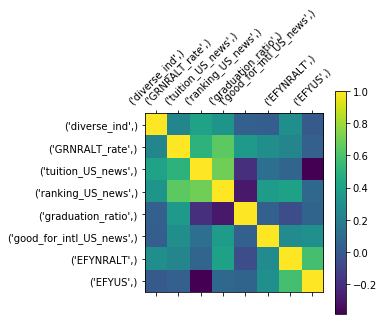

In [44]:
# correlation matrix
import matplotlib.pyplot as plt
print(feat_normalize.corr())
plt.matshow(feat_normalize.corr())
plt.colorbar()
plt.xticks(range(feat_normalize.shape[1]), feat_normalize.columns, fontsize=10, rotation=45)
plt.yticks(range(feat_normalize.shape[1]), feat_normalize.columns, fontsize=10)

In [80]:
binomial_normalized=glm.GLM(
    train_std[['EFYNRALT','EFYUS']], #[success, failure]
    train_std[features],
    family = sm.families.Binomial())
result=binomial_normalized.fit()
print(result.summary())
print(result.params)

                      Generalized Linear Model Regression Results                      
Dep. Variable:     [('EFYNRALT',), ('EFYUS',)]   No. Observations:                  191
Model:                                     GLM   Df Residuals:                      186
Model Family:                         Binomial   Df Model:                            4
Link Function:                           logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -3.2748e+05
Date:                         Mon, 30 Sep 2019   Deviance:                   6.5341e+05
Time:                                 17:51:59   Pearson chi2:                 6.17e+05
No. Iterations:                              6   Covariance Type:             nonrobust
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
('diverse_ind',)  

['diverse_ind', 'GRNRALT_rate', 'tuition_US_news', 'ranking_US_news', 'good_for_intl_US_news']


Text(0.5, 1.0, 'Binomial Regression coefficients')

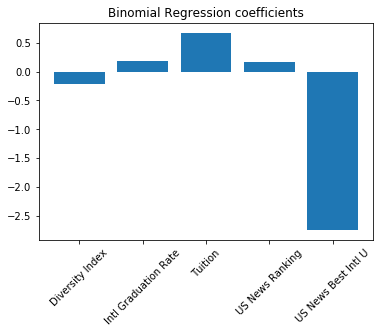

In [81]:
# coefficient plot
print(features)
feature_names = ['Diversity Index', 'Intl Graduation Rate','Tuition','US News Ranking','US News Best Intl U']
plt.bar(x = range(len(result.params)), height = result.params)
plt.xticks(range(len(result.params)), feature_names, rotation = 45)
plt.title('Binomial Regression coefficients')

In [57]:
plt.xticks?

# presentation 

For each institution, I will show a histogram of enrollment percent, with their location highlighted; I will also show their percentile for each feature; I will also show the projected improvement with certain changes!

In [56]:
def get_percentage(arr, reverse = False):
    n = arr.shape[0]
    if reverse == False:
        percentage = arr.rank(ascending=True)/n
    else:
        percentage = arr.rank(ascending=False)/n
    return(percentage)

#get_percentage(pd.Series(range(10)))

0    0.1
1    0.2
2    0.3
3    0.4
4    0.5
5    0.6
6    0.7
7    0.8
8    0.9
9    1.0
dtype: float64

In [62]:
# get the percentage for each feature
larger_good = [True,True,False,False,True]
for i in range(len(features)):
    data_274_intl_grad_national_u[str(features[i])+'_pct'] = get_percentage(
        data_274_intl_grad_national_u[features[i]], larger_good[i])
data_274_intl_grad_national_u.head()

C:\Users\Ning\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,UNITID,EFFYLEV,LSTUDY,XEYTOTLT,EFYTOTLT,XEYTOTLM,EFYTOTLM,XEYTOTLW,EFYTOTLW,XEFYAIAT,...,GRNRALM_rate,GRNRALW _rate,GRNRALT_rate_adj,graduation_ratio,EFYUS,diverse_ind_pct,GRNRALT_rate_pct,tuition_US_news_pct,ranking_US_news_pct,good_for_intl_US_news_pct
1,100663,2,1,R,13308,R,5528,R,7780,R,...,0.461538,0.777778,0.571621,1.080186,12944,0.518248,0.773723,0.189781,0.609489,0.308394
2,100706,2,1,R,7519,R,4287,R,3232,R,...,0.615385,0.000000,0.535915,1.102261,7302,0.620438,0.819343,0.142336,0.921533,0.808394
4,100751,2,1,R,35625,R,15883,R,19742,R,...,0.717647,0.750000,0.725785,1.069330,34595,0.864964,0.467153,0.335766,0.560219,0.308394
8,100858,2,1,R,23846,R,12374,R,11472,R,...,0.466667,0.571429,0.583067,0.761368,22568,0.916058,0.919708,0.364964,0.394161,0.808394
32,102049,2,1,R,3446,R,1197,R,2249,R,...,0.500000,1.000000,0.729032,0.961702,3357,0.956204,0.523723,0.434307,0.536496,0.808394


In [63]:
data_274_intl_grad_national_u.to_csv('Data/Data national universities 274.csv')

In [76]:
data_dropdown = data_274_intl_grad_national_u[['INSTNM','UNITID']]
data_dropdown = data_dropdown.rename(columns={'INSTNM': 'label', 'UNITID': 'value'})
data_dropdown = data_dropdown.T.to_dict()
list(data_dropdown.values())

[{'label': 'University of Alabama at Birmingham', 'value': 100663},
 {'label': 'University of Alabama in Huntsville', 'value': 100706},
 {'label': 'The University of Alabama', 'value': 100751},
 {'label': 'Auburn University', 'value': 100858},
 {'label': 'Samford University', 'value': 102049},
 {'label': 'University of Alaska Fairbanks', 'value': 102614},
 {'label': 'Arizona State University-Tempe', 'value': 104151},
 {'label': 'University of Arizona', 'value': 104179},
 {'label': 'University of Arkansas', 'value': 106397},
 {'label': 'Harding University', 'value': 107044},
 {'label': 'Azusa Pacific University', 'value': 109785},
 {'label': 'Biola University', 'value': 110097},
 {'label': 'California Institute of Technology', 'value': 110404},
 {'label': 'California State University-Fresno', 'value': 110556},
 {'label': 'University of California-Berkeley', 'value': 110635},
 {'label': 'University of California-Davis', 'value': 110644},
 {'label': 'University of California-Irvine', 'val

In [9]:
data = pd.read_csv('Data/Data national universities 274.csv')
data.head()

,Unnamed: 0,UNITID,EFFYLEV,LSTUDY,XEYTOTLT,EFYTOTLT,XEYTOTLM,EFYTOTLM,XEYTOTLW,EFYTOTLW,...,GRNRALM_rate,GRNRALW _rate,GRNRALT_rate_adj,graduation_ratio,EFYUS,diverse_ind_pct,GRNRALT_rate_pct,tuition_US_news_pct,ranking_US_news_pct,good_for_intl_US_news_pct
0,1,100663,2,1,R,13308,R,5528,R,7780,...,0.461538,0.777778,0.571621,1.080186,12944,0.518248,0.773723,0.189781,0.609489,0.308394
1,2,100706,2,1,R,7519,R,4287,R,3232,...,0.615385,0.000000,0.535915,1.102261,7302,0.620438,0.819343,0.142336,0.921533,0.808394
2,4,100751,2,1,R,35625,R,15883,R,19742,...,0.717647,0.750000,0.725785,1.069330,34595,0.864964,0.467153,0.335766,0.560219,0.308394
3,8,100858,2,1,R,23846,R,12374,R,11472,...,0.466667,0.571429,0.583067,0.761368,22568,0.916058,0.919708,0.364964,0.394161,0.808394
4,32,102049,2,1,R,3446,R,1197,R,2249,...,0.500000,1.000000,0.729032,0.961702,3357,0.956204,0.523723,0.434307,0.536496,0.808394


In [18]:
model_coefficients = [-0.1062,1.2622,-2.7071, -4.711e-06, -0.0103 ]
model_coefficients[3]*2

-9.422e-06